# HW2 Solution by YOUR NAME HERE

Instructions:

<https://www.cs.tufts.edu/cs/152BDL/2022f/hw2.html>

Outline

* Problem 0: Implementing HMC
* Problem 1: HMC Posterior for arch []
* Problem 2: Exact Posterior for arch []
* Problem 3: HMC Posterior for arch [64]

# Collaboration statement

TODO FILL. <<<<<<<<<< DON"T FORGET TO EDIT THIS COLLAB STATEMENT <<<<<<<<<

# Import packages

In [56]:
# Import numpy and other basic libraries
import numpy as np
import pandas as pd
import time, sys, os, platform

In [2]:
# Import scipy optimization routines
import scipy.optimize

In [3]:
## Import JAX
import jax
import jax.numpy as jnp
import jax.scipy.stats as jstats

In [4]:
# Import packages for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

In [5]:
uname = platform.uname()
B = 10
print("="*B, "Information about OS and CPU", "="*B)
print(f"Node Name: {uname.node}")
print(f"System: {uname.system}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}  Processor: {uname.processor}")
print("Num cores: ", os.cpu_count())

========== Information about OS and CPU ==========
Node Name: Michaels-MacBook-Pro-2.local
System: Darwin
Version: Darwin Kernel Version 20.6.0: Tue Feb 22 21:10:41 PST 2022; root:xnu-7195.141.26~1/RELEASE_X86_64
Machine: x86_64  Processor: i386
Num cores:  8


In [6]:
print("="*B, "Packages in local env", "="*B)
for pkg in [np, jax, matplotlib, sns]:
  print("%12s %s" % (pkg.__name__, pkg.__version__))

========== Packages in local env ==========
       numpy 1.22.4
         jax 0.3.17
  matplotlib 3.5.2
     seaborn 0.11.2


# Colab Setup

### If you are on Google Colab set `using_colab = True'

Then will clone the github and give you access to the extra .py files and the dataset CSV in starter code

### If not, don't need to do anything as long as you're running in the hw2 directory from starter code

In [59]:
using_colab = False

In [60]:
if using_colab:
    if not os.path.exists('cs152BDL-22f-assignments/hw2/'):
        !git clone https://github.com/tufts-ml-courses/cs152BDL-22f-assignments.git 
    os.chdir('cs152BDL-22f-assignments/hw2/')

In [65]:
# List .py files in current directory, for debugging purposes
!ls *.py

neural_net_regression_model.py        pytree_arithmetic_utils.py
neural_net_utils.py                   viz_utils_for_posterior_predictive.py


In [66]:
# List .csv files in current directory, for debuggin purposes
!ls *.csv

avg_deaths_per_day_in_middlesex_ma_2021__test.csv
avg_deaths_per_day_in_middlesex_ma_2021__train.csv
middlesex_ma_2021_deaths.csv


# Import utility functions distributed in .py files with starter code

In [7]:
%load_ext autoreload

In [8]:
from pytree_arithmetic_utils import (
    add_pytrees,
    multiply_pytree_and_scalar,
    subtract_pytree_and_scalar, subtract_pytrees)

In [9]:
import neural_net_utils
make_nn_params_as_list_of_dicts = neural_net_utils.make_nn_params_as_list_of_dicts
pretty_print_nn_param_list = neural_net_utils.pretty_print_nn_param_list
sample_nn_params_from_normal = neural_net_utils.sample_nn_params_from_normal
predict_f_given_x = neural_net_utils.predict_f_given_x

In [10]:
import neural_net_regression_model as model
calc_logpdf_likelihood = model.calc_logpdf_likelihood
calc_logpdf_prior = model.calc_logpdf_prior
sample_nn_params_from_prior = model.sample_nn_params_from_prior

In [11]:
import viz_utils_for_posterior_predictive as viz_utils

## Model hyperparameters

Should stay constant for all experiments in this notebook

In [12]:
model_hypers = {
    'w_mean':0.0, 'b_mean':0.0, 'w_stddev':3.0, 'b_stddev':3.0,
    'tau':0.3}

## Display settings

In [13]:
W, H = 6, 4  # set width/height of each panel

## Load data

In [14]:
df = pd.read_csv('avg_deaths_per_day_in_middlesex_ma_2021__train.csv')

In [15]:
raw_x_NF = df['days_since_211207'].astype(np.float32).values[:,np.newaxis].copy()
raw_y_N = df['deaths_avg'].astype(np.float32).values.copy()

### Standardize both x and y to have zero-mean, one-variance

In [16]:
def standardize_array_by_columns(a):
    return (a - np.mean(a, axis=0, keepdims=1)) / np.std(a, axis=0, keepdims=1)

standard_x_NF = standardize_array_by_columns(raw_x_NF)
standard_y_N = standardize_array_by_columns(raw_y_N)

### Display the data before/after standardization

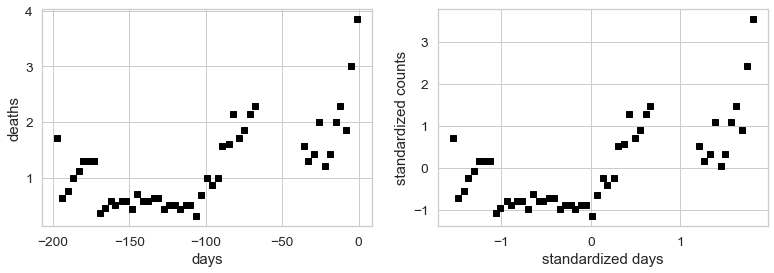

In [17]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(W*2+1, H),
                         sharey=False, sharex=False)
axgrid[0].plot(raw_x_NF, raw_y_N, 'ks');
axgrid[0].set_xlabel('days')
axgrid[0].set_ylabel('deaths')
axgrid[1].plot(standard_x_NF, standard_y_N, 'ks');
axgrid[1].set_xlabel('standardized days');
axgrid[1].set_ylabel('standardized counts');

### Use *standardized* data for all analyses below (you'll think about why in Problem 2d)

In [18]:
# Use standardized data

x_NF = 1.0 * standard_x_NF
y_N = 1.0 * standard_y_N

### Create test grid of x values (size T) to use to visualize predictions


In [19]:
T = 501
xrange = (np.max(x_NF) - np.min(x_NF))
xlo = x_NF.min() - 0.1 * xrange
xhi = x_NF.max() + 0.3 * xrange # show more forward in time
x_grid_T = np.linspace(xlo, xhi, T)
x_grid_T1 = x_grid_T.reshape((T,1))

# Problem 0: Implementing HMC

## 0a: Calculate potential energy

TODO fill in this function

**Hints**: You can call the provided functions `calc_logpdf_prior` and `calc_logpdf_likelihood`

In [20]:
def calc_potential_energy(nn_params, model_hypers):
    ''' Compute potential energy (PE) of given nn_params
    
    PE is the negative logpdf of posterior over weights, up to constant
    
    Args
    ----
    nn_params : PyTree
    model_hypers : dict
        Contains hyperparameters of model, via string keys
        - 'w_stddev'
        - 'b_stddev'
        - 'tau'
    
    Returns
    -------
    PE : scalar float
        potential energy of provided nn_params
    '''
    return -1.0 # TODO FIXME

## Gradient of potential energy

Just call JAX to get the gradient

In [21]:
calc_grad_potential_energy = jax.grad(calc_potential_energy)

## 0b: Calculate kinetic energy

TODO fill in this function

In [22]:
def calc_kinetic_energy(p):
    """ Compute kinetic energy of given momentum variables
    
    KE is the negative log pdf of the momentum variables
    Assumes Normal(mean zero, variance one) density for each entry of p
    
    Args
    ----
    p : PyTree
    
    Returns
    -------
    KE : scalar float
        kinetic energy of provided nn_params
    """
    placeholder_neg_logpdf = 0.0
    return placeholder_neg_logpdf
    # TODO iterate over layers of p, 
    # grab the 'w' and 'b' arrays in each layer
    # and compute kinetic energy of each

#### Test 0a and 0b functions to make sure they return scalars

In [23]:
init_q = sample_nn_params_from_normal([], 8675309, mean=0.0, stddev=1.0)
init_p = sample_nn_params_from_normal([], 8675309+1, mean=0.0, stddev=1.0)

In [24]:
print("Using momentum p PyTree with arch []")
pretty_print_nn_param_list(init_p)

print("KINETIC ENERGY is")
calc_kinetic_energy(init_p)

Using momentum p PyTree with arch []
Layer 0
  w | shape    (1, 1) | [-1.273]
  b | shape      (1,) | [ 1.750]
KINETIC ENERGY is


0.0

In [25]:
print("Using position q PyTree with arch []")
pretty_print_nn_param_list(init_q)

print("POTENTIAL ENERGY is")
calc_potential_energy(init_q, model_hypers)

Using position q PyTree with arch []
Layer 0
  w | shape    (1, 1) | [ 0.589]
  b | shape      (1,) | [ 0.733]
POTENTIAL ENERGY is


-1.0

## Useful utliity to update pytree via a step in direction of another pytree

This is provided as working code. Nothing to do here.

**Hint:** Call `update_step` later within `run_leapfrog_steps` in 0c

In [26]:
def update_step(a, b, step_length):
    ''' Performs a - step_length * b elementwise on a PyTree
    
    Args
    ----
    a : PyTree
    b : PyTree
    step_length : scalar float
    
    Returns
    -------
    c : PyTree
        Will have same shape as a 
        Each entry will equal a - step_length * b
    '''
    return subtract_pytrees(
        a,
        multiply_pytree_and_scalar(b, step_length))

## 0c : run_leapfrog_steps_along_consant_hamiltonian

TODO fill in this function.

Will evolve a start position-momentum (q,p)
into a new point (q', p') via deterministic leapfrog steps while "conserving" total energy

Remember, the Hamiltonian of a (q,p) is the total energy at that state, Kinetic + Potential.

In [27]:
def run_leapfrog_steps_along_constant_hamiltonian(
        q,
        p,
        n_leapfrog_steps=10,
        step_size=0.01,
        model_hypers={},
        update_step=update_step,
        calc_potential_energy=None,
        calc_grad_potential_energy=None,
        ):
    """ Executes many leapfrog steps to evolve given (q,p) location to new (q',p')
    
    Args
    ----
    q : jax PyTree
        Contains starting "location" params defining neural net
    p : jax PyTree
        Contains starting "momentum" params, same size as q
    
    Returns
    -------
    prop_q : jax PyTree
        Contains new "location" params defining neural net
    prop_p : jax PyTree
        Contains new "momentum" params, same size as prop_q
    
    References
    ----------
    See Neal's pseudocode algorithm for notation used
    https://arxiv.org/pdf/1206.1901.pdf#page=14
    """
    grad_wrt_q = calc_grad_potential_energy(q, model_hypers)

    # FIRST STEP: half step update of p
    # TODO update p by taking HALF step in direction of grad_wrt_q
    # using update_step(...)
    
    # for steps 1, 2, .... L-1
    for step_id in range(n_leapfrog_steps-1):
        q = multiply_pytree_and_scalar(q, 1.0) # FIXME
        # TODO update q by taking FULL step in direction of p
        # using update_step(...)
        
        # TODO recompute grad_wrt_q
        
        # TODO update p by taking FULL step in direction of grad_wrt_q
        # using update_step(...)
        
    # FINAL STEP
    # TODO update q by taking FULL step in direction of p
    # using update_step(...)

    # TODO update p by taking HALF step in direction of grad_wrt_q
    # using update_step(...)
        
    # Flip direction to make reversible
    p = multiply_pytree_and_scalar(p, -1.0)
    return q, p

## Compile all functions so things run fast!

In [28]:
fast_update_step = jax.jit(update_step)
fast_potential_energy = jax.jit(calc_potential_energy)
fast_grad_potential_energy = jax.jit(calc_grad_potential_energy)
fast_kinetic_energy = jax.jit(calc_kinetic_energy)

## Speed test the baseline (no use of jax.jit)

In [29]:
n_leapfrog_steps = 10
step_size = 0.001

start_time_sec = time.time()
new_q, new_p = run_leapfrog_steps_along_constant_hamiltonian(
    init_q, init_p,
    n_leapfrog_steps=n_leapfrog_steps,
    step_size=step_size,
    calc_potential_energy=calc_potential_energy,
    calc_grad_potential_energy=calc_grad_potential_energy,
    update_step=update_step,
    model_hypers=model_hypers)
elapsed_time_sec = time.time() - start_time_sec

print("NEW POSITION after L=%d steps" % n_leapfrog_steps)
pretty_print_nn_param_list(new_q)
print("after %.3f sec" % elapsed_time_sec)

NEW POSITION after L=10 steps
Layer 0
  w | shape    (1, 1) | [ 0.589]
  b | shape      (1,) | [ 0.733]
after 0.053 sec


## Speedtest the faster code (using jax.jit)

We observe ~100x faster executions of `run_leapfrog_steps` with JIT-ified code

In [30]:
n_leapfrog_steps = 10
step_size = 0.001

for trial in range(2):
    start_time_sec = time.time()
    new_q, new_p = run_leapfrog_steps_along_constant_hamiltonian(
        init_q, init_p,
        n_leapfrog_steps=n_leapfrog_steps,
        step_size=step_size,
        calc_potential_energy=fast_potential_energy,
        calc_grad_potential_energy=fast_grad_potential_energy,
        update_step=fast_update_step,
        model_hypers=model_hypers)
    elapsed_time_sec = time.time() - start_time_sec

    print("trial %d: NEW POSITION after L=%d steps" % (trial, n_leapfrog_steps))
    pretty_print_nn_param_list(new_q)
    print("after %.3f sec" % elapsed_time_sec)
    print("       ^^^^<<<< pay attention to later calls, first is always slower" if trial > 0 else '')

trial 0: NEW POSITION after L=10 steps
Layer 0
  w | shape    (1, 1) | [ 0.589]
  b | shape      (1,) | [ 0.733]
after 0.017 sec

trial 1: NEW POSITION after L=10 steps
Layer 0
  w | shape    (1, 1) | [ 0.589]
  b | shape      (1,) | [ 0.733]
after 0.000 sec
       ^^^^<<<< pay attention to later calls, first is always slower


# 0d: Procedure to sample from posterior via many iterations of HMC

Most of this function is provided to you as working starter code.

TODO your tasks are:

* FIX the acceptance calculation

In [31]:
def draw_samples_from_posterior_via_HMC(
        n_dims_per_hidden_list,
        n_samples_keep=100,
        n_samples_burnin=1000,
        n_leapfrog_steps=10,
        step_size=0.01,
        random_state=42,
        model_hypers={},
        init_nn_params='fromprior',        # sample first position from the prior
        update_step=None,
        calc_potential_energy=None,
        calc_kinetic_energy=None,
        calc_grad_potential_energy=None,
        print_early=3,                     # print for the first so many iters
        print_every=100,                   # print message every so many iters
        print_first_weight_and_bias=False, # include w,b values in the printout
        ):
    ''' Draw samples of neural-net weight/biases via HMC MCMC
    
    Args
    ----
    n_dims_per_hidden_list : list of int
        Defines architecture to explore
    n_samples_keep : int
        Desired number of samples to keep (after burnin)
    n_samples_burnin : int
        Desired number of samples during burnin period
        
    Returns
    -------
    list_of_samples : list of PyTree
    info : dict
        History of the Markov chain, for debugging purposes
    '''
    assert isinstance(random_state, int)
    random_state_int = random_state
    random_state = np.random.RandomState(random_state_int)

    if init_nn_params == 'fromprior':
        init_nn_params = sample_nn_params_from_prior(
            n_dims_per_hidden_list,
            random_state=random_state_int,
            prior_params=model_hypers)
    
    init_msg = "Running HMC for %5d burnin then %4d samples | random_state %d" % (
        n_samples_burnin, n_samples_keep, random_state_int)
    print(init_msg)
        
    # Instantiate the current parameters from initialization
    # and calculate current PE
    cur_q = multiply_pytree_and_scalar(init_nn_params, 1.0)
    cur_PE = calc_potential_energy(cur_q, model_hypers)

    start_time_sec = time.time()
    n_accept = 0
    history_of_q = list()
    history_of_PE = list()
    history_of_E = list()
    
    S = n_samples_keep + n_samples_burnin
    for ss in range(S):
        # Sample momentum from its Normal distribution.
        # This step can be thought of as a "random walk" 
        # across level sets of phase space.
        cur_p = sample_nn_params_from_normal(
            n_dims_per_hidden_list, random_state, mean=0.0, stddev=1.0)

        # Determine current kinetic and total energy
        # reusing cur_PE previously calculated
        cur_KE = calc_kinetic_energy(cur_p)
        cur_E = cur_KE + cur_PE
        
        # Propose new location/momentum via leapfrog
        # by surfing along the level set of constant total energy
        prop_q, prop_p = run_leapfrog_steps_along_constant_hamiltonian(
            cur_q, cur_p,
            n_leapfrog_steps=n_leapfrog_steps,
            step_size=step_size,
            update_step=update_step,
            calc_grad_potential_energy=calc_grad_potential_energy,
            model_hypers=model_hypers)
        
        # Calculate proposed potential and total energy
        prop_PE = calc_potential_energy(prop_q, model_hypers)
        prop_KE = calc_kinetic_energy(prop_p)
        prop_E = prop_KE + prop_PE
        
        # Decide to accept or reject
        accept_proba = 1.0 # TODO FIXME
        do_accept = True   # TODO FIXME, may need to draw a uniform value (use `random_state` as your PRNG)
        if do_accept:
            cur_q = prop_q
            cur_PE = prop_PE
            cur_KE = prop_KE
            cur_E = prop_E
            n_accept += 1

        # Store current state
        history_of_q.append(cur_q)
        history_of_E.append(cur_E)
        history_of_PE.append(cur_PE)
        
        # Print useful messages for debugging every few iterations
        if ss < print_early or ((ss+1) % print_every == 0) or (ss+1) == S:
            accept_rate = float(n_accept) / float(ss+1)
            msg = "iter %6d/%d after %7.1f sec  PE % .4e  accept_rate %.3f" % (
                ss+1, S, time.time() - start_time_sec, cur_PE, accept_rate)
            if print_first_weight_and_bias:
                msg += "  w % .3f b % .3f" % (
                    cur_q[0]['w'][0], cur_q[0]['b'][0])
            print(msg)

    print("") # Blank line after the chain finishes
    return (
        history_of_q,
        history_of_PE,
        dict(n_accept=n_accept, n_attempt=ss+1, accept_rate=accept_rate,
            history_of_E=history_of_E, history_of_PE=history_of_PE),
    )

# Problem 1: HMC posterior for arch []

### Prep for Experiment 1: Define target arch and settings for the HMC MCMC

In [32]:
arch1 = []

In [33]:
# MCMC settings for experiment 1
sampler_options_1 = dict(
    n_samples_keep = 200,
    n_samples_burnin = 10,  # TODO TUNE ME, be sure you've burned in
    step_size=0.1,          # TODO TUNE ME
    n_leapfrog_steps=5,    # TODO TUNE ME
    model_hypers=model_hypers,
    update_step=fast_update_step,
    calc_potential_energy=fast_potential_energy,
    calc_kinetic_energy=fast_kinetic_energy,
    calc_grad_potential_energy=fast_grad_potential_energy,
    print_every=200,
    print_first_weight_and_bias=True,
    )

In [34]:
chain_list = [1, 2, 3]

# Place to store result of each chain
history1_nn_samples_by_chain = {}
history1_PE_by_chain = {}

### Run Experiment 1: 3 chains

In [35]:
for chain_id in chain_list:
    print("Chain %d/%d" % (chain_id, len(chain_list)))
    history1_nn_samples_by_chain[chain_id], history1_PE_by_chain[chain_id], _ = draw_samples_from_posterior_via_HMC(
        arch1,
        random_state=1000 + chain_id, # every chain should initialize to a new draw from prior
        **sampler_options_1)

Chain 1/3
Running HMC for    10 burnin then  200 samples | random_state 1001
iter      1/210 after     0.0 sec  PE -1.0000e+00  accept_rate 1.000  w -0.338 b -8.828
iter      2/210 after     0.0 sec  PE -1.0000e+00  accept_rate 1.000  w -0.338 b -8.828
iter      3/210 after     0.0 sec  PE -1.0000e+00  accept_rate 1.000  w -0.338 b -8.828
iter    200/210 after     0.1 sec  PE -1.0000e+00  accept_rate 1.000  w -0.338 b -8.828
iter    210/210 after     0.2 sec  PE -1.0000e+00  accept_rate 1.000  w -0.338 b -8.828

Chain 2/3
Running HMC for    10 burnin then  200 samples | random_state 1002
iter      1/210 after     0.0 sec  PE -1.0000e+00  accept_rate 1.000  w -3.963 b  3.894
iter      2/210 after     0.0 sec  PE -1.0000e+00  accept_rate 1.000  w -3.963 b  3.894
iter      3/210 after     0.0 sec  PE -1.0000e+00  accept_rate 1.000  w -3.963 b  3.894
iter    200/210 after     0.1 sec  PE -1.0000e+00  accept_rate 1.000  w -3.963 b  3.894
iter    210/210 after     0.1 sec  PE -1.0000e+00  ac

## 1a: Plot of potential energy vs. sampler iteration

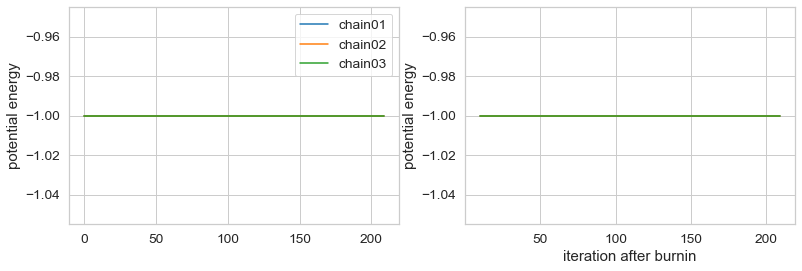

In [36]:
axL, axR = viz_utils.plot_potential_energy_of_samples(history1_PE_by_chain, sampler_options_1)
#axL.set_ylim([0, 1000]);
#axR.set_ylim([140, 155]);

## Prep for 1b: Draw S samples of y_* at each of the test inputs for all chains

In [37]:
B, S = sampler_options_1['n_samples_burnin'], sampler_options_1['n_samples_keep']
y_ST_by_chain = {}
for chain in chain_list:
    prng = np.random.RandomState(1000 * chain + 1)
    y_ST = 0.5 * prng.randn(S,T)
    # TODO FIXME draw y_* from its posterior predictive 
    # By using the kept samples of q from history1_nn_samples_by_chain[chain]
    # Be sure to discard the first B burnin samples!
    y_ST_by_chain[chain] = y_ST

## 1b: Visualizing posterior predictive over function values and outputs

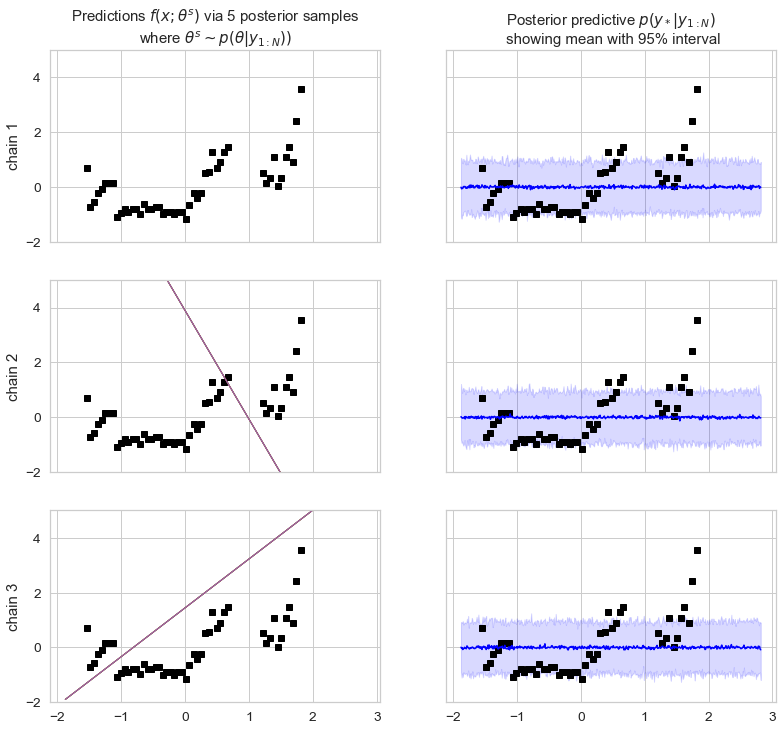

In [38]:
viz_utils.show_posterior_predictive_samples_and_intervals(
    history1_nn_samples_by_chain, y_ST_by_chain,
    x_grid_T=x_grid_T,
    x_NF=x_NF, y_N=y_N, sampler_options=sampler_options_1)
plt.ylim([-2, 5]);

## 1c : Convergence assessment (short answer)

TODO WRITE THIS

## 1d : Tuning assessment (short answer)

TODO WRITE THIS

# Problem 2: Exact posterior for arch = []

### Prepare for Experiment 2

In [39]:
# Define feature transform, so that f = w * x + b where x is univariate input

def phi(x_NF):
    N = x_NF.shape[0]
    return np.hstack([x_NF, np.ones((N,1))])

In [40]:
phi_NG = phi(x_NF)
G = phi_NG.shape[1]
print("Number of features produced by our transform: G=%d" % G)

Number of features produced by our transform: G=2


### Define exact posterior's mean and covariance

Formulas were derived in the day01-B notes

<https://www.cs.tufts.edu/cs/152BDL/2022f/notes/day01-B-BayesLinearRegression%2BKernels.html#Part-3:-Posterior-over-weights-in-closed-form>

In [41]:
# Compute the covariance matrix of shape (G,G) of the posterior

post_covar_GG = np.eye(G) # TODO FIXME

In [42]:
# Compute the mean vector (size G) of the posterior

post_mean_G = 1.0 * np.arange(G) # TODO FIXME

### Experiment 2: Draw samples from the exact posterior, repeated 3 times

You shouldn't need to modify this code, it just draws lots of samples from the exact posterior defined above.

Although we call the 3 sets "chains", there's nothing Markov about these, they are all independent samples from exact posterior.

In [43]:
arch2 = []

In [44]:
sampler_options_2 = {
    'n_samples_keep':200,
    'n_samples_burnin':10, # keep same as in Problem 1
}

B = int(sampler_options_2['n_samples_burnin'])
S = int(sampler_options_2['n_samples_keep'])

In [45]:
exact_samples_by_chain = {}
exact_PE_by_chain = {}

for chain in chain_list:
    
    exact_samples_by_chain[chain] = []
    exact_PE_by_chain[chain] = []
    prng = np.random.RandomState(1000 * chain + 1)

    for sample_id in range(B+S):
        # Draw from the posterior, as a 1D array
        w_then_b_G = prng.multivariate_normal(post_mean_G, post_covar_GG)
    
        # Create nn PyTree that we can fill with sampled values from posterior
        nn_params = make_nn_params_as_list_of_dicts(1, 1, arch2) # filled with all zeros, will be overwritten
        nn_params[0]['w'][:] = w_then_b_G[0] # overwrite the weight
        nn_params[0]['b'][:] = w_then_b_G[1] # overwrite the bias
        
        # Add the parameters to our growing list of all samples
        exact_samples_by_chain[chain].append(nn_params)
        # Add the PE to our growing list of all PE values
        exact_PE_by_chain[chain].append(fast_potential_energy(nn_params, model_hypers))

## 2a: Plot of potential energy over EXACT samples

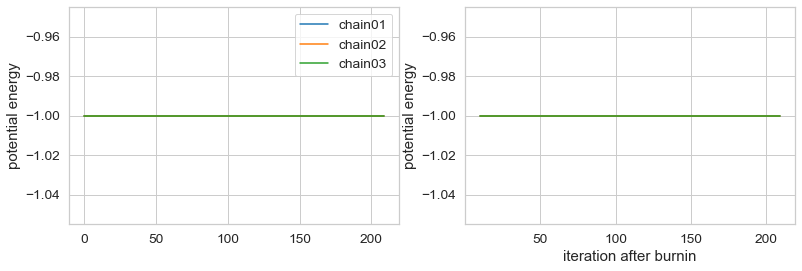

In [46]:
axL, axR = viz_utils.plot_potential_energy_of_samples(exact_PE_by_chain, sampler_options_2)
#axL.set_ylim([0, 1000]);
#axR.set_ylim([140, 155]);

## Prep for 2b: Draw S samples of y_* at each of the test inputs for all chains

In [47]:
B, S = sampler_options_2['n_samples_burnin'], sampler_options_2['n_samples_keep']
exact_y_ST_by_chain = {}
for chain in chain_list:
    prng = np.random.RandomState(1000 * chain + 1)
    y_ST = 0.5 * prng.randn(S,T)
    # TODO FIXME draw y_* from its posterior predictive 
    # By using the kept samples of q from current chain's history
    # Be sure to discard the first B burnin samples!
    exact_y_ST_by_chain[chain] = y_ST

## 2b: Visualizing EXACT posterior predictive over function values and outputs

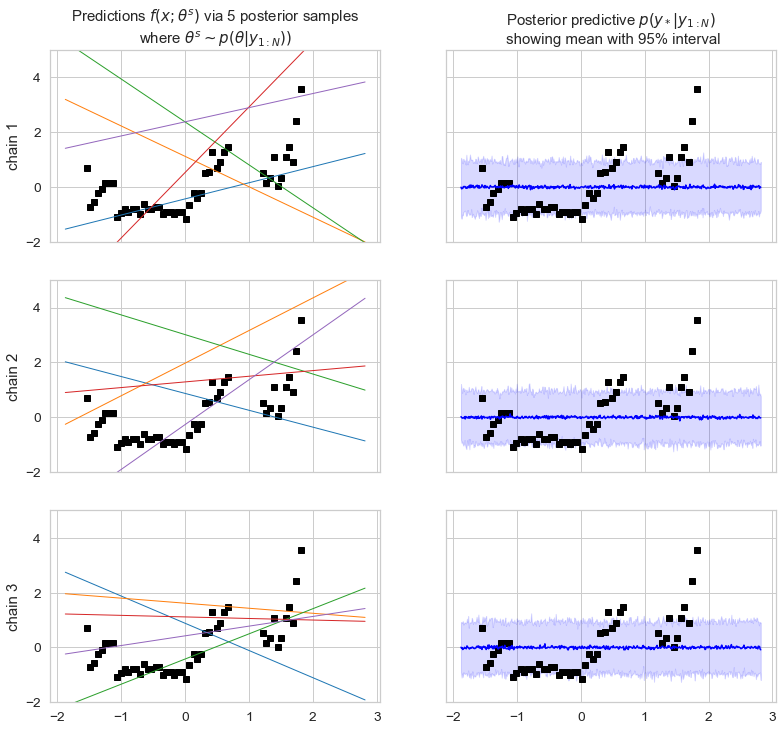

In [48]:
viz_utils.show_posterior_predictive_samples_and_intervals(
    exact_samples_by_chain, exact_y_ST_by_chain,
    x_grid_T=x_grid_T,
    x_NF=x_NF, y_N=y_N, sampler_options=sampler_options_2)
plt.ylim([-2, 5]);

## 2c: HMC vs Exact (short answer)

TODO WRITE ANSWER HERE

## 2d: Purpose of standardization (short answer)

TODO WRITE ANSWER HERE

# Problem 3: HMC Posterior for arch [64]

In [49]:
arch3 = [64]

In [50]:
# MCMC settings
sampler_options_3 = dict(
    n_samples_keep = 2000,
    n_samples_burnin = 10,   # TODO TUNE ME
    step_size=0.1,           # TODO TUNE ME
    n_leapfrog_steps=5,      # TODO TUNE ME
    model_hypers=model_hypers,
    print_every=2000,
    print_first_weight_and_bias=False,
    update_step=fast_update_step,
    calc_potential_energy=fast_potential_energy,
    calc_kinetic_energy=fast_kinetic_energy,
    calc_grad_potential_energy=fast_grad_potential_energy,
    )

In [51]:
chain_list = [1, 2, 3]

# Place to store result of each chain
history3_nn_samples_by_chain = {}
history3_PE_by_chain = {}

In [52]:
for chain_id in chain_list:
    print("Chain %d/%d" % (chain_id, len(chain_list)))
    history3_nn_samples_by_chain[chain_id], history3_PE_by_chain[chain_id], _ = \
        draw_samples_from_posterior_via_HMC(
            arch3,
            random_state=1000 * chain_id + 1,
            **sampler_options_3)

Chain 1/3
Running HMC for    10 burnin then 2000 samples | random_state 1001
iter      1/2010 after     0.0 sec  PE -1.0000e+00  accept_rate 1.000
iter      2/2010 after     0.0 sec  PE -1.0000e+00  accept_rate 1.000
iter      3/2010 after     0.0 sec  PE -1.0000e+00  accept_rate 1.000
iter   2000/2010 after     1.6 sec  PE -1.0000e+00  accept_rate 1.000
iter   2010/2010 after     1.6 sec  PE -1.0000e+00  accept_rate 1.000

Chain 2/3
Running HMC for    10 burnin then 2000 samples | random_state 2001
iter      1/2010 after     0.0 sec  PE -1.0000e+00  accept_rate 1.000
iter      2/2010 after     0.0 sec  PE -1.0000e+00  accept_rate 1.000
iter      3/2010 after     0.0 sec  PE -1.0000e+00  accept_rate 1.000
iter   2000/2010 after     1.5 sec  PE -1.0000e+00  accept_rate 1.000
iter   2010/2010 after     1.5 sec  PE -1.0000e+00  accept_rate 1.000

Chain 3/3
Running HMC for    10 burnin then 2000 samples | random_state 3001
iter      1/2010 after     0.0 sec  PE -1.0000e+00  accept_rate 1.0

## 3a: Plot potential energy over samples

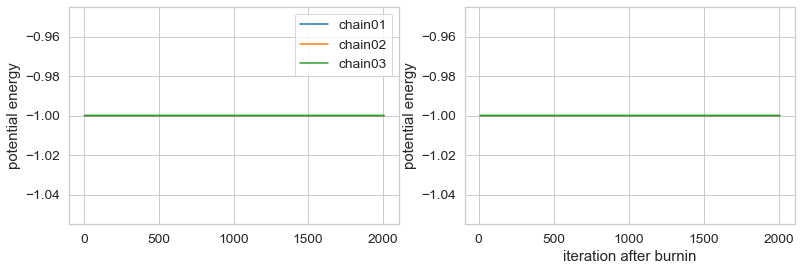

In [53]:
axL, axR = viz_utils.plot_potential_energy_of_samples(history3_PE_by_chain, sampler_options_3)
#axL.set_ylim([0, 1000]);  # TODO suggested ylims should work OK a good implementation

## Prep for 3b: Draw S samples of y_* at each of the test inputs for all chains

In [54]:
B, S = sampler_options_3['n_samples_burnin'], sampler_options_3['n_samples_keep']
history3_y_ST_by_chain = {}
for chain in chain_list:
    prng = np.random.RandomState(1000 * chain + 1)
    y_ST = 0.5 * prng.randn(S,T)
    # TODO FIXME draw y_* from its posterior predictive 
    # By using the kept samples of q from current chain's history
    # Be sure to discard the first B burnin samples!
    history3_y_ST_by_chain[chain] = y_ST

## 3b: Visualizing posterior predictive over function values and outputs

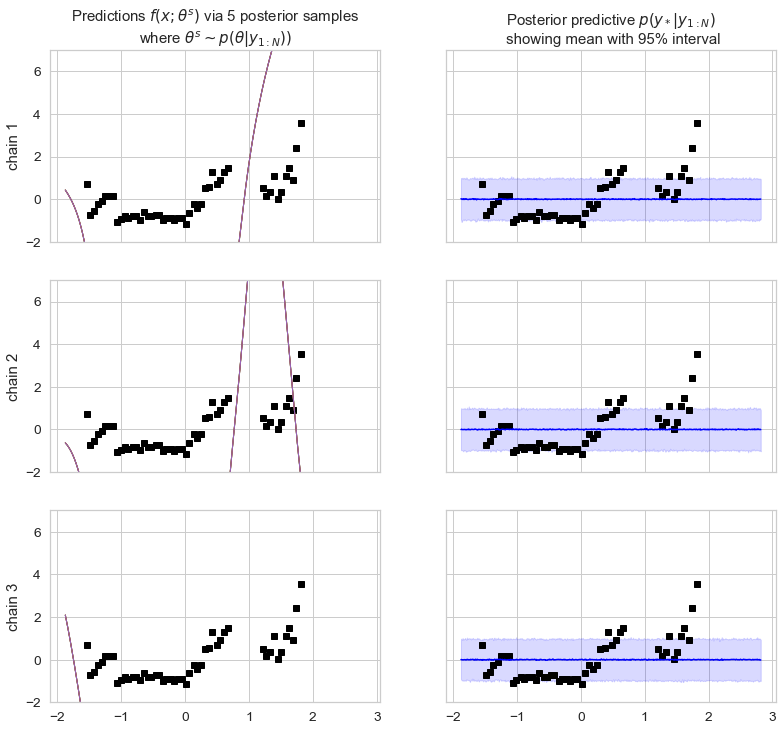

In [55]:
viz_utils.show_posterior_predictive_samples_and_intervals(
    history3_nn_samples_by_chain, history3_y_ST_by_chain,
    x_grid_T=x_grid_T, x_NF=x_NF, y_N=y_N, sampler_options=sampler_options_3)
plt.ylim([-2, 7]);

## 3c: Convergence assessment (short answer)

TODO WRITE THIS

## 3d : Tuning assessment (short answer)

TODO WRITE THIS